# Customer Segmentation
- Nama : Rahmat Fajri
- Email : rfajri912@gmail.com
- [Portofoli](https://rfajri27.github.io/MyPortfolio/)

Project ini menggunakan data customer dari [automobile company](https://www.kaggle.com/vetrirah/customer) yang berencana memasuki pasar baru dengan menggunakn produk mereka yang telah ada. Pada project ini akan dilakukan customer segmentation untuk mengidentifikasi customer baru yang potensial.

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.preprocessing import LabelEncoder
from kmodes.kmodes import KModes  
from kmodes.kprototypes import KPrototypes   
import pickle  
from pathlib import Path  

In [2]:
sns.set(style='darkgrid')

## Load Data

In [3]:
df = pd.read_csv('data/data/Train.csv')

df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
# menghilangkan Anonymised Category for the customer
df.drop(['Var_1', 'Segmentation'], axis=1, inplace=True)

df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


In [5]:
kolom_numerik = ['Age', 'Family_Size', 'Work_Experience']
kolom_kategorikal = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']

## Data Cleansing

In [6]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [7]:
df.nunique()

ID                 8068
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
dtype: int64

### Checking for Missing Values

In [8]:
df.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

#### Handling missing value
Pada kolom numerik akan dilakukan imputation dengan menggunakan **nilai median**. Sedangkan pada kolom kategorikal akan dilakukan imputation dengan menggunakan **Unknown**

In [9]:
for kol in kolom_numerik:
    med = df[kol].median()
    df[kol].fillna(med, inplace=True)

In [10]:
for kol in kolom_kategorikal:
    df[kol].fillna('Unknown', inplace=True)

In [11]:
df.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [12]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0


### Find Outlier

C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


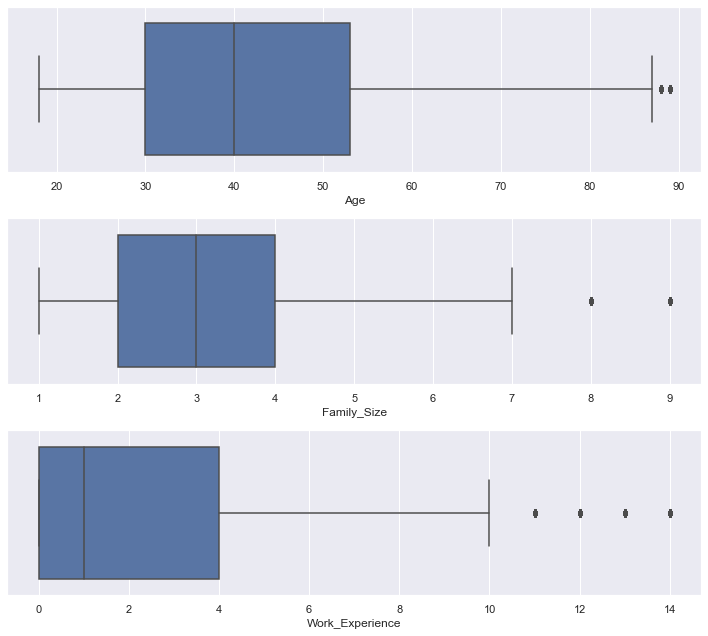

In [13]:
def box_plot(features):  
    fig, axs = plt.subplots(len(features), 1, figsize=(10, 9))
    for i, kol in enumerate(features):
        sns.boxplot(df[kol], ax = axs[i])
    plt.tight_layout()
    plt.show()

box_plot(kolom_numerik) 

#### Handling outlier
Outlier dapat diatasi dengan menggunakan metode interquartile range (IQR)

In [14]:
Q1 = (df[kolom_numerik]).quantile(0.25)
Q3 = (df[kolom_numerik]).quantile(0.75)
IQR = Q3 - Q1

maximum = Q3 + (1.5*IQR)
minimum = Q1 - (1.5*IQR)

kondisi_more_than = (df > maximum)
kondisi_lower_than = (df < minimum)

In [15]:
df = df.mask(kondisi_more_than, maximum, axis=1)
df = df.mask(kondisi_lower_than, minimum, axis=1)

### Find Not Standar Values

In [16]:
for kol in kolom_kategorikal:
    print(df[kol].value_counts())

Male      4417
Female    3651
Name: Gender, dtype: int64
Yes        4643
No         3285
Unknown     140
Name: Ever_Married, dtype: int64
Yes        4968
No         3022
Unknown      78
Name: Graduated, dtype: int64
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Unknown           124
Name: Profession, dtype: int64
Low        4878
Average    1974
High       1216
Name: Spending_Score, dtype: int64


## Exploratory Data Analysis

C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.wa

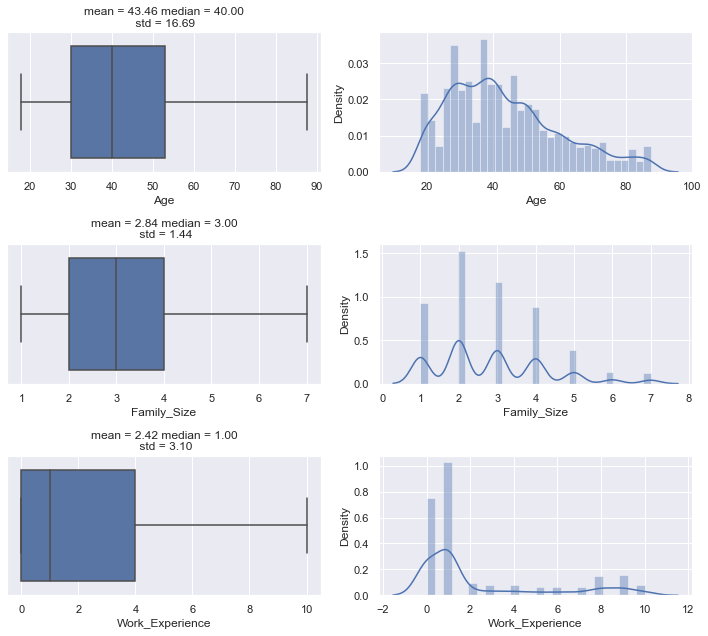

In [17]:
def observasi_num(features):  
    fig, axs = plt.subplots(len(features), 2, figsize=(10, 9))
    for i, kol in enumerate(features):
        sns.boxplot(df[kol], ax = axs[i][0])
        sns.distplot(df[kol], ax = axs[i][1])   
        axs[i][0].set_title('mean = %.2f median = %.2f\n std = %.2f'%(df[kol].mean(), 
                                                                        df[kol].median(), 
                                                                        df[kol].std()))
    plt.tight_layout()
    plt.show()

observasi_num(kolom_numerik)

C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\li

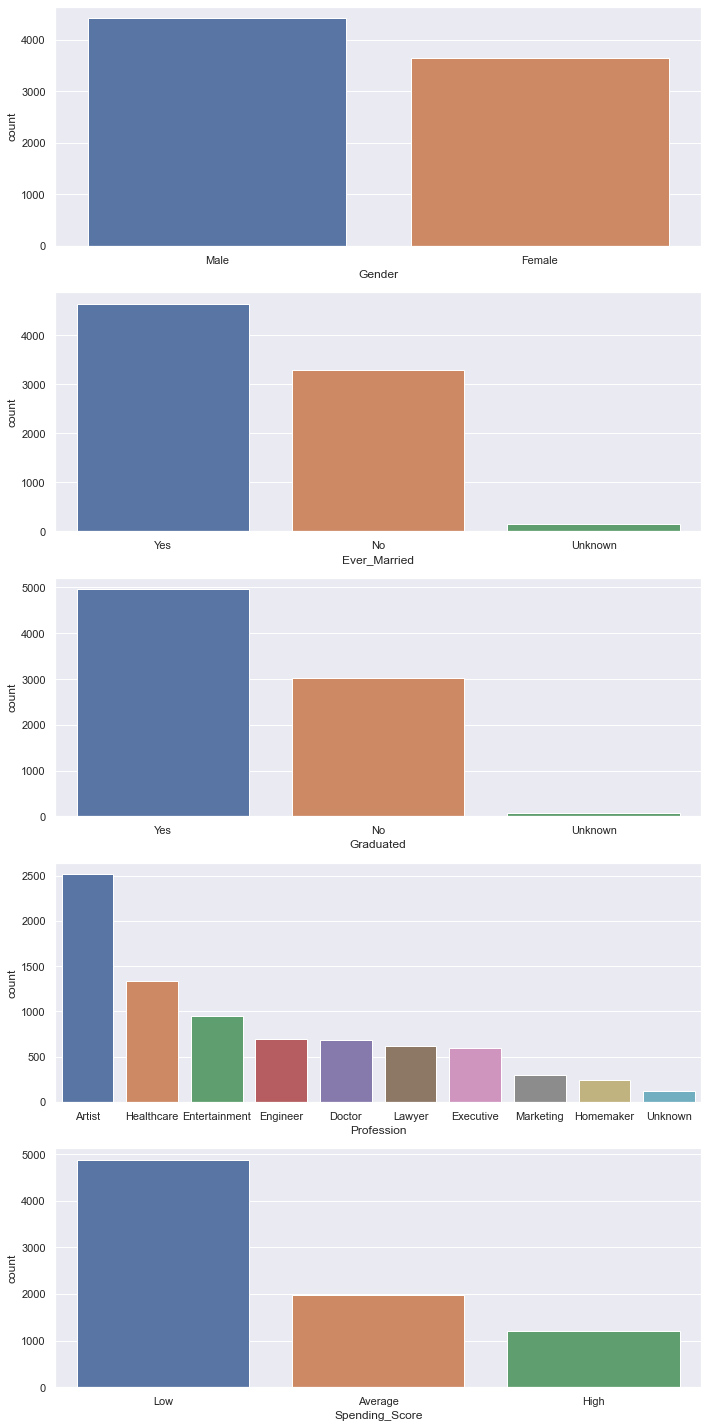

In [18]:
def observasi_kat(features):
    fig, axs = plt.subplots(len(features),1,figsize=(10,20))
    for i, kol in enumerate(features):
        sns.countplot(df[kol], order = df[kol].value_counts().index, ax = axs[i])  
        
    plt.tight_layout()
    plt.show()
    
observasi_kat(kolom_kategorikal)

## Data Preprocessing

In [19]:
cleaned_df = df.drop(['ID'], axis=1)
cleaned_df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22.0,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38.0,Yes,Engineer,1.0,Average,3.0
2,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40.0,Yes,Entertainment,1.0,High,6.0


In [20]:
cleaned_df.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,8068.000000
mean,43.458044,2.415469,2.839241
std,16.687991,3.101948,1.441754
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,87.500000,10.000000,7.000000


In [21]:
# Decimal Scaling
cleaned_df['Age'] = cleaned_df['Age'] / 10

### Encoding Categorical Data

In [22]:
for kol in kolom_kategorikal:
    cleaned_df[kol] = LabelEncoder().fit_transform(cleaned_df[kol])

cleaned_df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0,2.2,0,5,1.0,2,4.0
1,0,2,3.8,2,2,1.0,0,3.0
2,0,2,6.7,2,2,1.0,2,1.0
3,1,2,6.7,2,7,0.0,1,2.0
4,0,2,4.0,2,3,1.0,1,6.0


In [23]:
cleaned_df.describe()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
count,8068.000000,8068.000000,8068.000000,8068.000000,8068.000000,8068.000000,8068.000000,8068.000000
mean,0.547471,1.168319,4.345804,1.241200,2.885226,2.415469,1.359941,2.839241
std,0.497772,0.976952,1.668799,0.965541,2.631486,3.101948,0.848418,1.441754
min,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,1.000000,2.000000,4.000000,2.000000,3.000000,1.000000,2.000000,3.000000
75%,1.000000,2.000000,5.300000,2.000000,5.000000,4.000000,2.000000,4.000000
max,1.000000,2.000000,8.750000,2.000000,9.000000,10.000000,2.000000,7.000000


## Modelling using K-Prototypes Algorithm 

### Measuring Cluster Criteria

In [ ]:
cost = {}
for k in range(1,10):
    model = KPrototypes(n_clusters=k, random_state=75)
    model.fit_predict(cleaned_df, categorical=[0,1,3,4,6])
    cost[k]= model.cost_ 

# Memvisualisasikan Elbow Plot  
sns.pointplot(x=list(cost.keys()), y=list(cost.values()))  
plt.show()

### Training Model using $K = 5$

In [ ]:
k = 5

model = KPrototypes(n_clusters=k, random_state=75)
model.fit_predict(cleaned_df, categorical=[0,1,3,4,6])

# Save model
pickle.dump(kproto, open('cluster_model.pkl', 'wb'))  